In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from nltk.tokenize import casual_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load data

In [2]:
def load_data(file_path) :
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    return df[["headline", "category"]]
dataframe = load_data('data.json')
dataframe[:]

,headline,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT
...,...,...
200848,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH
200849,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS
200850,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS
200851,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   headline  200853 non-null  object  
 1   category  200853 non-null  category
dtypes: category(1), object(1)
memory usage: 1.7+ MB


In [4]:
dataframe.isnull().sum()

headline    0
category    0
dtype: int64

In [5]:
print("We have a total of {} categories :".format(dataframe['category'].nunique()))
dataframe['category'].value_counts()

We have a total of 41 categories :


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

# Clasification data

#### explore_data

In [6]:
def explore_data(df, number_of_bins=30, text_only=False):
    stats = get_key_statistics_about_data(df)
    print("Number of samples:", stats["n_samples"])
    print("Number of classes:", stats["n_classes"])
    print("Number of empty headlines:", stats["n_empty_headlines"])
    print("Number of missing headlines:", stats["n_missing_headlines"])
    print("Number of missing classes:", stats["n_missing_classes"])
    print("Samples per class: Min:", stats["min_n_samples_per_class"], "Median:", stats["median_n_samples_per_class"],
         "Max:", stats["max_n_samples_per_class"])
    print("Words per sample: Min:", stats["min_n_words_per_sample"], "Median:", stats["median_n_words_per_sample"],
         "Max:", stats["max_n_words_per_sample"])
    print("Samples / Median number of words per sample:", stats["n_samples"] / stats["median_n_words_per_sample"])
    print()
    display(df["category"].value_counts().to_frame())
    
    if not text_only:
        plot_class_distribution(df["category"])

        plot_word_count_distribution(df["headline"], bins=number_of_bins)
        plot_frequency_distribution_of_ngrams(df["headline"])

#### key_statistics Analysis

In [7]:
def get_key_statistics_about_data(df):
    ret = dict()
    ret["n_samples"] = len(df)
    ret["n_classes"] = len(df["category"].unique())
    ret["n_missing_headlines"] = df["headline"].isnull().sum()
    ret["n_empty_headlines"] = len(df[df["headline"] == ""])
    ret["n_missing_classes"] = df["category"].isnull().sum()
    number_of_words_per_sample = df["headline"].apply(lambda x: len(x.split()))
    ret["n_words_per_sample"] = number_of_words_per_sample
    ret["min_n_words_per_sample"] = number_of_words_per_sample.min()
    ret["median_n_words_per_sample"] = number_of_words_per_sample.median()
    ret["max_n_words_per_sample"] = number_of_words_per_sample.max()
    number_of_samples_per_class = df["category"].value_counts()
    ret["min_n_samples_per_class"] = number_of_samples_per_class.min()
    ret["median_n_samples_per_class"] = number_of_samples_per_class.median()
    ret["max_n_samples_per_class"] = number_of_samples_per_class.max()
    
    return ret

#### Class distribution

In [8]:
def plot_class_distribution(labels):
    counts = labels.value_counts()
    plt.figure(figsize=(16, 8))
    plt.bar(counts.index, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(counts.index, counts.index, rotation=90)
    plt.show()

#### Word count distribution

In [9]:
def plot_word_count_distribution(sample_texts, bins=30):
    plt.figure(figsize=(16, 8))
    plt.hist([len(s.split()) for s in sample_texts], bins)
    plt.xlabel('Word count')
    plt.ylabel('Number of samples')
    plt.title('Word count distribution')
    plt.show()

#### Frequency distribution of n-grams

In [10]:
def plot_frequency_distribution_of_ngrams(sample_texts,ngram_range=(1, 2),num_ngrams=50):
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(16, 8))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

#### Explore All Data

Number of samples: 200853
Number of classes: 41
Number of empty headlines: 6
Number of missing headlines: 0
Number of missing classes: 0
Samples per class: Min: 1004 Median: 3405.0 Max: 32739
Words per sample: Min: 0 Median: 10.0 Max: 44
Samples / Median number of words per sample: 20085.3



,category
POLITICS,32739
WELLNESS,17827
ENTERTAINMENT,16058
TRAVEL,9887
STYLE & BEAUTY,9649
PARENTING,8677
HEALTHY LIVING,6694
QUEER VOICES,6314
FOOD & DRINK,6226
BUSINESS,5937


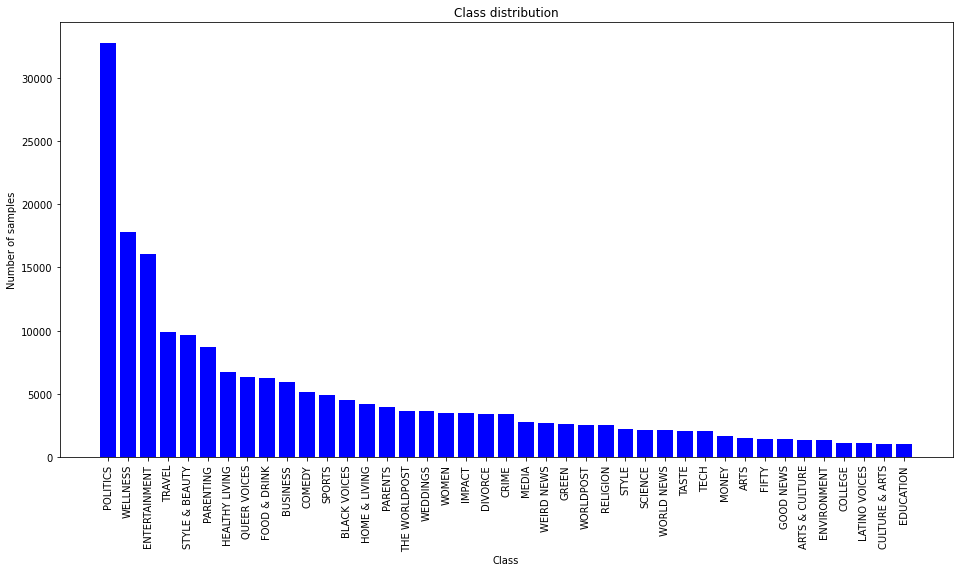

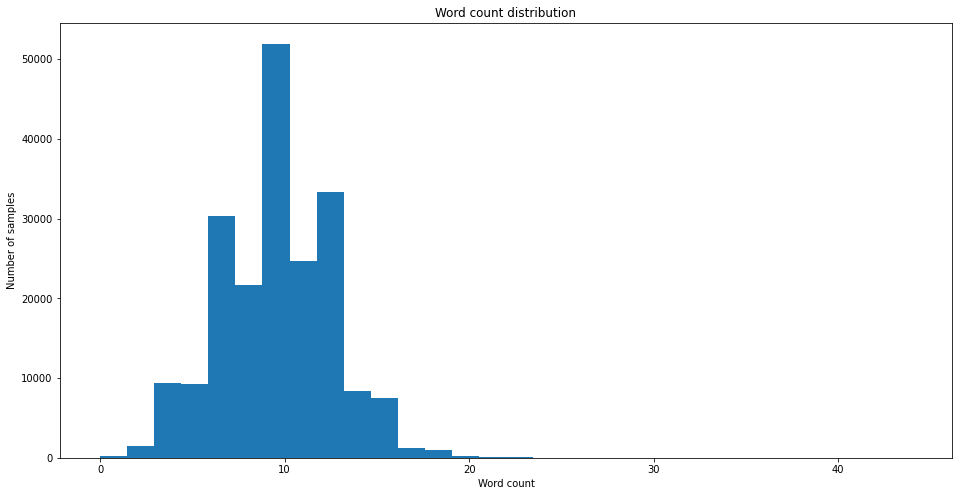

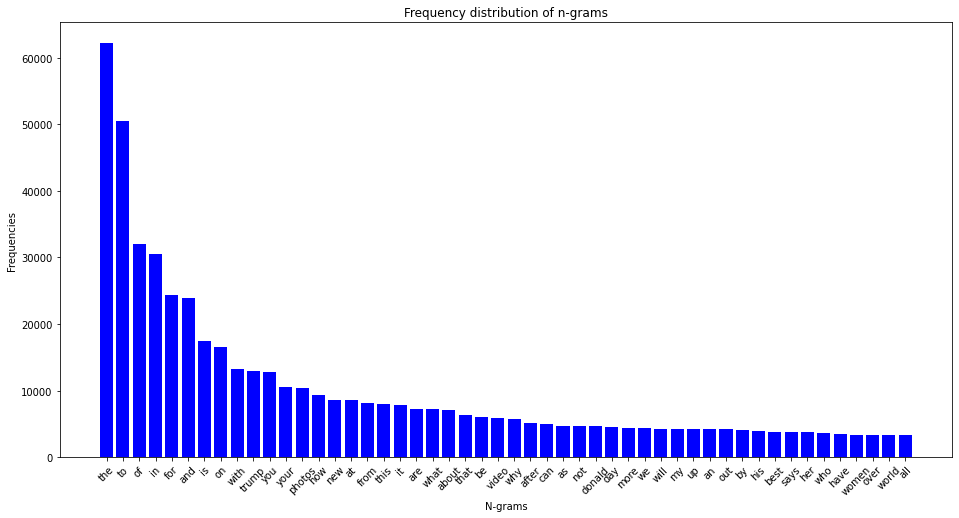

In [11]:
explore_data(dataframe)

# FIFTY category

In [12]:
display(dataframe[dataframe["category"] == "FIFTY"])

,headline,category
35278,"Love, Facebook and Infidelity",FIFTY
38400,"Boomers Were Time's ""Man of the Year"" Fifty Ye...",FIFTY
38986,Be Grateful At The Holidays For Sprinkles Of H...,FIFTY
39037,A No Bullsh-t Holiday Letter,FIFTY
39629,How Our Vocabulary Gives Away Our Age,FIFTY
...,...,...
124796,Middle-aged and Invisible at Coachella,FIFTY
124835,How A Dinner Party Changed My Outlook On Aging,FIFTY
124836,What Kind Of Inheritance Do You Really Owe You...,FIFTY
124848,Eight Factors To Consider When Choosing Your O...,FIFTY


# IMPACT category

In [13]:
display(dataframe[dataframe["category"] == "IMPACT"])

,headline,category
12,"With Its Way Of Life At Risk, This Remote Oyst...",IMPACT
66,Monsanto And Bayer Are Set To Merge. Here's Wh...,IMPACT
125,You're Going To Use That Self-Checkout Machine...,IMPACT
193,Machines Don't Always Steal Our Jobs. Increasi...,IMPACT
286,She Started A Suicide Prevention Site At Age 1...,IMPACT
...,...,...
200762,"Texana Hollis, 101-Year-Old Evicted Detroit Wo...",IMPACT
200763,"Malaria's Defeat, Africa's Future",IMPACT
200825,Tinker and Change the World,IMPACT
200826,Pregnant and Displaced: Double the Danger,IMPACT


# WOMEN category

In [14]:
display(dataframe[dataframe["category"] == "WOMEN"])

,headline,category
35,Morgan Freeman Dropped From Marketing Campaign...,WOMEN
67,The Joy Of Watching Harvey Weinstein’s Perp Walk,WOMEN
68,The 20 Funniest Tweets From Women This Week,WOMEN
79,Morgan Freeman Accused Of Inappropriate Behavi...,WOMEN
274,What Do You Say To Sexist Passengers? This Fem...,WOMEN
...,...,...
124915,7 Ways to Cook up Chemistry Through Conversation,WOMEN
124955,The Power of the Purse: An Untapped Opportunity,WOMEN
124967,'It's Complicated': How I Learned to Fend off ...,WOMEN
124981,Millennial Women Don't Lack Confidence -- They...,WOMEN


# WELLNESS category

In [15]:
display(dataframe[dataframe["category"] == "WELLNESS"])

,headline,category
124989,Why Overeating Doesn't Make You Fat,WELLNESS
124990,14 Habits Of People With A Healthy Relationshi...,WELLNESS
124993,5 Things That Could Be Stealing Your Joy,WELLNESS
124994,Moments Make a Life,WELLNESS
124996,Fat Facts,WELLNESS
...,...,...
200797,Shoveling Snow? How to Protect Your Back (And ...,WELLNESS
200799,7 Reasons Working Too Much Is Bad For Your Health,WELLNESS
200800,The Sleep Library: 11 Soothing Books For Bedtime,WELLNESS
200802,The Benefits of Caring for a Pet,WELLNESS


# Assigning numeric values to the categories

In [16]:
def codify_labels(df):
    label = dict( zip( df['category'].cat.codes, df['category'] ) )
    category_code = dict( zip( df['category'], df['category'].cat.codes ) )
    df['category'] = df.category.cat.codes
    return label, category_code

label, category_code = codify_labels(dataframe)
display(label)

{6: 'CRIME',
 10: 'ENTERTAINMENT',
 39: 'WORLD NEWS',
 18: 'IMPACT',
 24: 'POLITICS',
 36: 'WEIRD NEWS',
 2: 'BLACK VOICES',
 38: 'WOMEN',
 5: 'COMEDY',
 25: 'QUEER VOICES',
 28: 'SPORTS',
 3: 'BUSINESS',
 34: 'TRAVEL',
 20: 'MEDIA',
 32: 'TECH',
 26: 'RELIGION',
 27: 'SCIENCE',
 19: 'LATINO VOICES',
 9: 'EDUCATION',
 4: 'COLLEGE',
 23: 'PARENTS',
 1: 'ARTS & CULTURE',
 29: 'STYLE',
 15: 'GREEN',
 31: 'TASTE',
 16: 'HEALTHY LIVING',
 33: 'THE WORLDPOST',
 14: 'GOOD NEWS',
 40: 'WORLDPOST',
 12: 'FIFTY',
 0: 'ARTS',
 37: 'WELLNESS',
 22: 'PARENTING',
 17: 'HOME & LIVING',
 30: 'STYLE & BEAUTY',
 8: 'DIVORCE',
 35: 'WEDDINGS',
 13: 'FOOD & DRINK',
 21: 'MONEY',
 11: 'ENVIRONMENT',
 7: 'CULTURE & ARTS'}

In [17]:
categories = dataframe["category"].unique()
display(categories)

array([ 6, 10, 39, 18, 24, 36,  2, 38,  5, 25, 28,  3, 34, 20, 32, 26, 27,
       19,  9,  4, 23,  1, 29, 15, 31, 16, 33, 14, 40, 12,  0, 37, 22, 17,
       30,  8, 35, 13, 21, 11,  7], dtype=int8)

# Splitting the data into training, validation, and test data

In [18]:
def split_dataset(df, seed=42, percentage_train=0.8, percentage_validation=0.15, percentage_test=0.05):
    assert percentage_train + percentage_validation + percentage_test == 1

    dataset_size = len(df)
    
    headlines_train, headlines_rest, categories_train, categories_rest = train_test_split(df["headline"], df["category"], random_state=seed, test_size=0.2)
    headlines_validation, headlines_test, categories_validation, categories_test = train_test_split(headlines_rest, categories_rest, random_state=seed, test_size=0.25)

    train_df = pd.concat([categories_train, headlines_train], axis=1)
    train_df.columns = ["category", "headline"]
    validation_df = pd.concat([categories_validation, headlines_validation], axis=1)
    validation_df.columns = ["category", "headline"]
    test_df = pd.concat([categories_test, headlines_test], axis=1)
    test_df.columns = ["category", "headline"]
    
    return train_df, validation_df, test_df
train_df, validation_df, test_df = split_dataset(dataframe)

display(train_df[:])

,category,headline
66880,3,Martin Shkreli Wants To Be The Only One To Own...
68387,23,Panel Recommends Depression Screening For Preg...
100514,15,200 Yellowstone Bison Allegedly Sent To Slaughter
197218,30,Abercrombie & Fitch Employees Forced To Do Pus...
144020,37,"Life's Path Is a Maze, Not a Straight Line"
...,...,...
119879,16,Overwhelmed? 7 Strategies for Restoring Balance
103694,26,Single Dad Of 5 Can't Afford Christmas Present...
131932,30,"Pharrell's Hat Has A Twitter, Because Of Course"
146867,17,Easy Storage Solutions From A To Z


# Computing class weights

In [19]:
class_weights = dict(zip(train_df["category"].unique(), class_weight.compute_class_weight('balanced', train_df["category"].unique(), train_df["category"])))

c:\python\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 3 23 15 30 37 32 20 25 24  2 18 10 16  6  8 34 28  5 29 17 35 27 22 33
 12 13 31  4 26 11 38 36 21  7 39 40 14 19  9  0  1], y=66880      3
68387     23
100514    15
197218    30
144020    37
          ..
119879    16
103694    26
131932    30
146867    17
121958    14
Name: category, Length: 160682, dtype: int8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [20]:
display({label[category_code]: weight for category_code, weight in class_weights.items()})

{'BUSINESS': 0.8137610404343246,
 'PARENTS': 1.2355211761449267,
 'GREEN': 1.8600252352784563,
 'STYLE & BEAUTY': 0.5112946080537126,
 'WELLNESS': 0.2730871138409663,
 'TECH': 2.382415301356661,
 'MEDIA': 1.7257037299567184,
 'QUEER VOICES': 0.7797598827560102,
 'POLITICS': 0.14926959324820824,
 'BLACK VOICES': 1.0748966458397442,
 'IMPACT': 1.4184122948721345,
 'ENTERTAINMENT': 0.30335731641239316,
 'HEALTHY LIVING': 0.7322632979693026,
 'CRIME': 1.4225310964543403,
 'DIVORCE': 1.4355579379969623,
 'TRAVEL': 0.4976600851722803,
 'SPORTS': 1.0132040255252603,
 'COMEDY': 0.9542423108672284,
 'STYLE': 2.1869827961672472,
 'HOME & LIVING': 1.1709211744044539,
 'WEDDINGS': 1.3603169631140948,
 'SCIENCE': 2.2575306283016747,
 'PARENTING': 0.5660128784996689,
 'THE WORLDPOST': 1.3334716470676105,
 'FIFTY': 3.46207877273119,
 'FOOD & DRINK': 0.7899764504599289,
 'TASTE': 2.392596563328271,
 'COLLEGE': 4.3496927533093315,
 'RELIGION': 1.9043115504041337,
 'ENVIRONMENT': 3.739573636194377,
 'WO